# Basic imports...

In [2]:
import sys
import data_loaders
import features
import parameters
import training
import pandas as pd

import collections

from hamilton import driver
from typing import List, Dict, Any
from hamilton import base

# Magic for developing -- allows reloading

If you like developing externall like I do, this is critical. If not, we have tooling to write functions in a notebook (and would love feedback on developing more).

In [3]:
# Some magic for developing...
# Functions can also be inside the notebook if you want
import importlib
# load extension
%load_ext autoreload
# configure autoreload to only affect specified files
%autoreload 1
# import & specify modules to be reloaded
# i.e. this is the data transformation module that I have open in other tab
%aimport training
%aimport features

# Hamilton on Ice

This should really be part of the framework, but I put it here to illustrate it.
It's pretty simple -- all it does is manage external state.

In [4]:
# This is the basic prototype of a stateful hamilton DAG
# Note that this generates data that just repeats and updates state
# It does not *yet* know about streaming inputs, although I think we can do that.
# This is basically a state machine, where the output of the last run gets fed into the 
# input of the next one
class HamiltonOnIce:
    def __init__(self, 
                 driver: driver.Driver, 
                 remember: List[str], 
                 outputs: List[str],
                 inputs: Dict[str, Any]):
        """Initializes a Hamilton on Ice driver. This calls a hamilton DAG in a 
        sequential chain, in which the state from the prior run is passed into 
        the inputs to the current run as overrides.
        
        We know which nodes to pass in due to the value of the tag `feedback`.
        For example,
        
        @tag(feedback="output_optimizer")
        def optimizer(...) -> ...:
            ...
            
        means that `optimizer` will only be called the first time. On subsequent 
        loads, the prior value of `output_optimizer` will be called.
        
        Each HamiltonOnIce instance stores the state in itself, so you'll want to create a 
        new one to iterate through again.
        
        :param driver: hamilton driver to use
        :param remember: list of items to store after finishing -- these will be accessible in the `memory` 
            property
        :param inputs: constant list of inputs to the DAG
        :param outputs: outputs we finally care about in the end, but don't necessarily want to remember
        """
        self._driver = driver
        self._feedback_nodes = {
            var.name: var.tags["feedback"] for var in self._driver.list_available_variables() if "feedback" in var.tags
        }
        self._memory = []
        self._remember = remember
        self._inputs = inputs
        self._outputs = outputs
        self._feedback = {}
        self._iteration = 0
        
    @property
    def memory(self) -> Dict[str, List[Any]]:
        """Gives the memory out as a dict of node names -> list(values)"""
        output = collections.defaultdict(list)
        for state in self._memory:
            for key, value in state.items():
                output[key].append(value)
        return output
            
    def __iter__(self):
        """Need to decide how to reset state/whanot, this works for now..."""
        return self
    
    def __next__(self):
        """Single iteration of a hamilton run"""
        vars_ = set([*self._remember, *self._outputs, *sorted(self._feedback_nodes.values())])
        result = self._driver.execute(
            vars_, # We execute the vars we care about
            inputs={**self._inputs, "iteration": self._iteration}, 
            overrides=self._feedback,
        )
        self._iteration += 1
        self._feedback = {key: result[value] for key, value in self._feedback_nodes.items()}
        self._memory.append({key: result[key] for key in self._remember}) # Remember the memory
        return {key: result[key] for key in self._outputs} # return the output

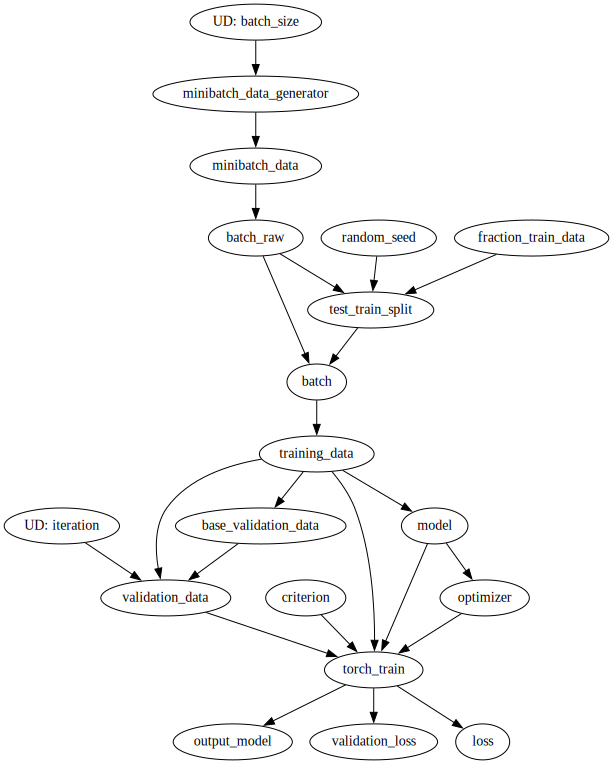

In [36]:
dr = driver.Driver(
    {"fine_grained_lineage": False, "batch_size" : 32},
#     {"fine_grained_lineage": True, "batch_size" : 32}, # enable if you want to use fine-grained lineage (features as their own functions)
    data_loaders,
    parameters,
    training,
    features,
    adapter=base.SimplePythonGraphAdapter(base.DictResult())
)
# Visualize execution, for fun
dr.visualize_execution(
    ['validation_loss', 'loss', 'output_model'],
    None, #change to "outfile" or something if you want it to pop up, and not just show here
    {},
    inputs={"iteration" : 0}
)

In [38]:
# Instantiate a basic "HamiltonOnIce" driver
ice = HamiltonOnIce(
    driver=dr, # Pass in the driver
    remember=["loss", "validation_loss", "batch_number"], # Remember the loss
    outputs=["output_model", "batch_number"],
    inputs={} # paths, everything, is hardcoded
)

# Actual iterations

Note that only use one loop (as opposed to two nested loops).
This is something where we'd like to clean up the ergonomics.

In [40]:
# Run through each epoch
# Not doing mini-batches -- that's up next!
last_epoch = 0
result = {"batch_number" : 0}
while (epoch:=result["batch_number"]) <= 200:
    if (epoch % 10) == 0 and last_epoch != epoch:
        print(f"epoch: {epoch}")
    result = next(ice)
    last_epoch = epoch
epochs = pd.DataFrame.from_records(ice.memory)

<Axes: xlabel='batch_number'>

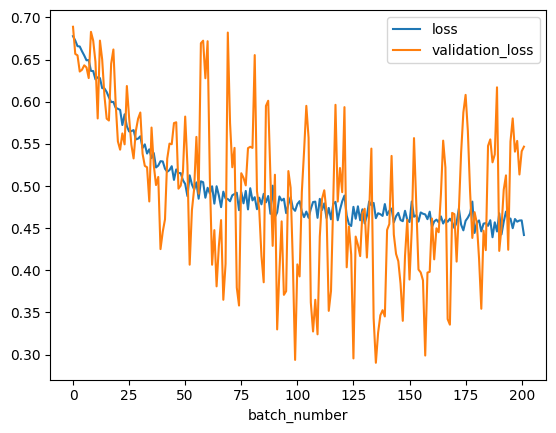

In [41]:
epochs.groupby("batch_number").mean().plot()